In [1]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import time
import Generator
import Discriminator

AUTOTUNE = tf.data.experimental.AUTOTUNE

# loading dataset from file
dataset_real = glob.glob("/home/ragavendrankk/celebA_ds/*")
dataset_comic = glob.glob("/home/ragavendrankk/facemaker_ds/*")

# Count of dataset
dataset_real_count = 30000
dataset_comic_count = 26020

# Training count
dataset_real_training_count = int(dataset_real_count * 0.8)
dataset_comic_training_count = int(dataset_comic_count * 0.8)

# Split training and test dataset
train_comic, train_real = tf.data.Dataset.from_tensor_slices(dataset_comic[0:dataset_comic_training_count]), tf.data.Dataset.from_tensor_slices(dataset_real[0:dataset_real_training_count])
test_comic, test_real = tf.data.Dataset.from_tensor_slices(dataset_comic[dataset_comic_training_count:dataset_comic_count]), tf.data.Dataset.from_tensor_slices(dataset_real[dataset_real_training_count:dataset_real_count])

BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 64
IMG_HEIGHT = 64

In [2]:
def train_parse_func(filename):
    # Read the image
    image_string = tf.io.read_file(filename)

    # Decode the image
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)

    # Normalize the image
    image = tf.cast(image_decoded, tf.float32)
    image = (image / 255)

    # resizing to 72 x 72 x 3
    image = tf.image.resize(image, [72, 72],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 64 x 64 x 3
    image = tf.image.random_crop(
        image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

In [3]:
def test_parse_func(filename):
    # Read the image
    image_string = tf.io.read_file(filename)

    # Decode the image
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)

    # Normalize the image
    image = tf.cast(image_decoded, tf.float32)
    image = (image / 255)

    return image

In [4]:
train_comic = train_comic.map(
    train_parse_func, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_real = train_real.map(
    train_parse_func, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_comic = test_comic.map(
    test_parse_func, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_real = test_real.map(
    test_parse_func, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

print("Done Pre processing")

Done Pre processing


In [5]:
# Model creation
generator = Generator.create_generator()
discriminator = Discriminator.create_discriminator()

In [6]:
# Sample image from data set
sample_comic = next(iter(train_comic))
sample_real = next(iter(train_real))

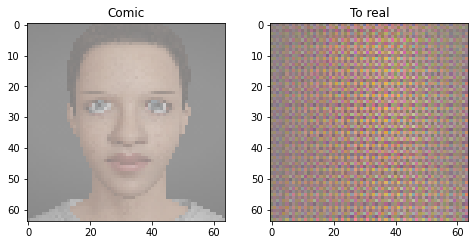

In [8]:
# Generating real image before training
to_real = generator(sample_comic)

plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_comic, to_real]
title = ['Comic', 'To real']

for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [9]:
LAMBDA = 10

In [10]:
# Binary cross entropy loss object
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
# Generator and Discriminator loss
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [12]:
# Optimizer for generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [13]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator=generator,
                           discriminator=discriminator,
                           generator_optimizer=generator_optimizer,
                           discriminator_optimizer=discriminator_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [14]:
EPOCHS = 40

In [15]:
# generating image during training and printing
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(title[i])

        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')

    plt.show()

In [16]:
@tf.function
def train_step(real_x, real_y):

    with tf.GradientTape(persistent=True) as tape:
        # Generator translates X -> Y

        fake_y = generator(real_x, training=True)

        disc_real_y = discriminator(real_y, training=True)

        disc_fake_y = discriminator(fake_y, training=True)

        # calculate the loss
        gen_loss = generator_loss(disc_fake_y)
        disc_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_gradients = tape.gradient(gen_loss,
                                          generator.trainable_variables)

    discriminator_gradients = tape.gradient(disc_loss,
                                              discriminator.trainable_variables)

    # Apply the gradients to the optimizer
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                  discriminator.trainable_variables))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

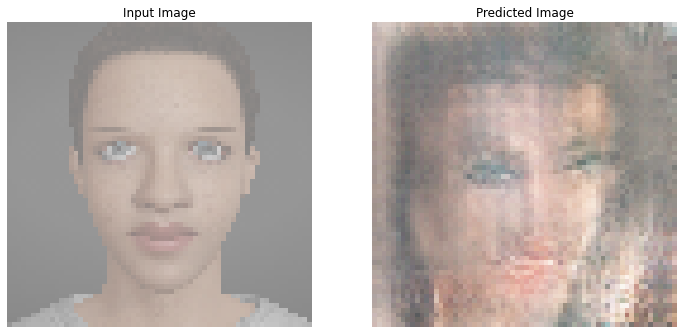

Time taken for epoch 1 is 641.7234673500061 sec

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

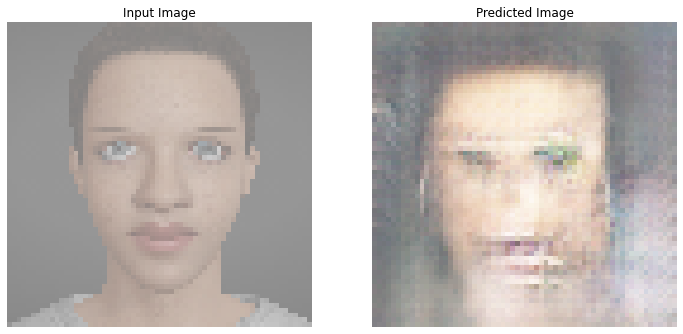

Time taken for epoch 2 is 638.8639299869537 sec

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

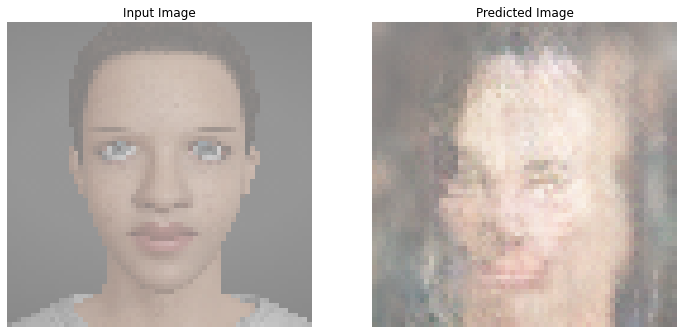

Time taken for epoch 3 is 657.5465052127838 sec

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

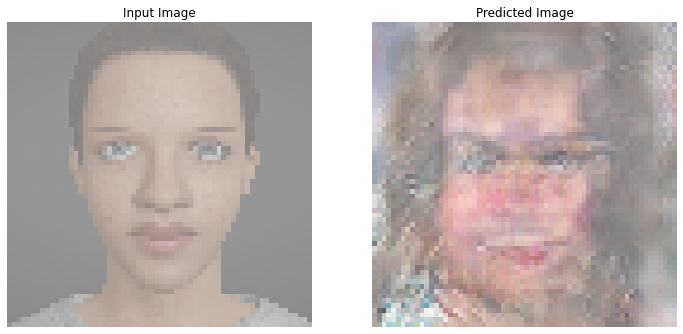

Time taken for epoch 4 is 656.8478517532349 sec

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

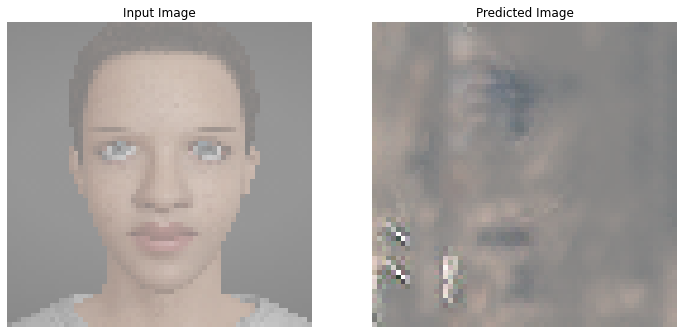

Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-1
Time taken for epoch 5 is 656.9918704032898 sec

...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

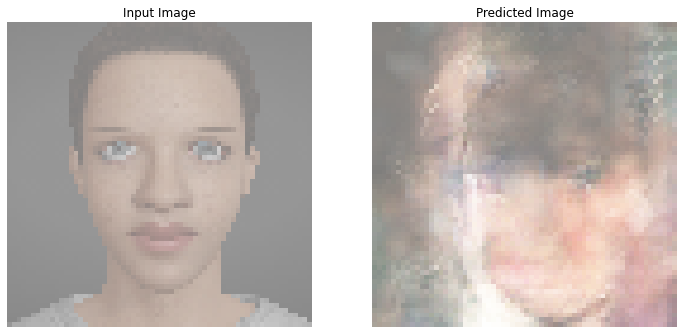

Time taken for epoch 6 is 640.6184470653534 sec

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

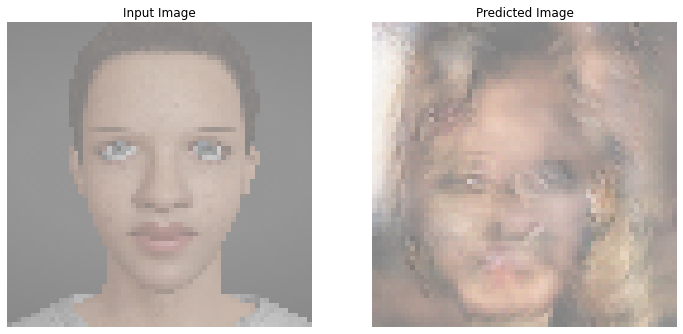

Time taken for epoch 7 is 657.3143055438995 sec

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

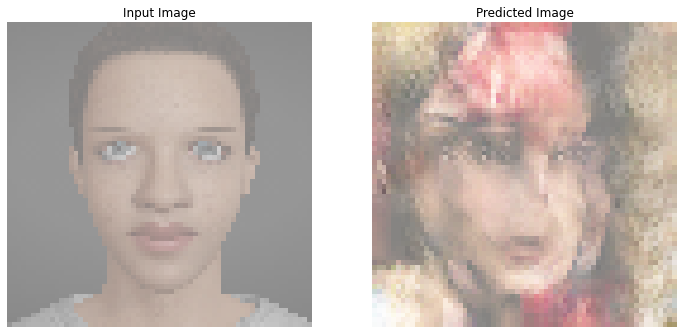

Time taken for epoch 8 is 654.5073239803314 sec

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

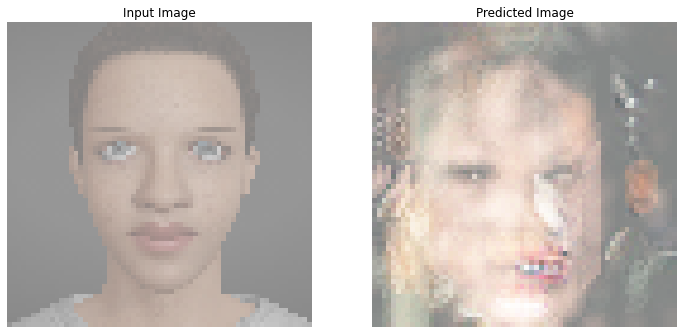

Time taken for epoch 9 is 655.4395503997803 sec

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

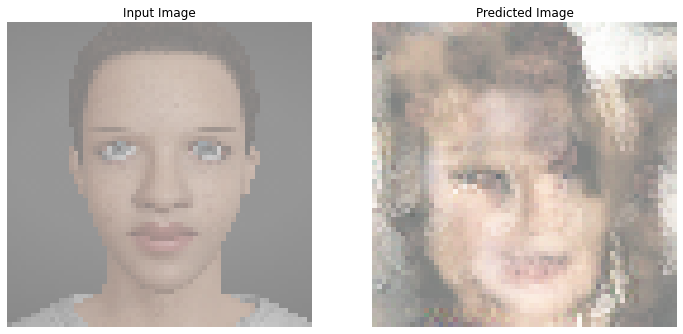

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Time taken for epoch 10 is 656.8913559913635 sec

.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

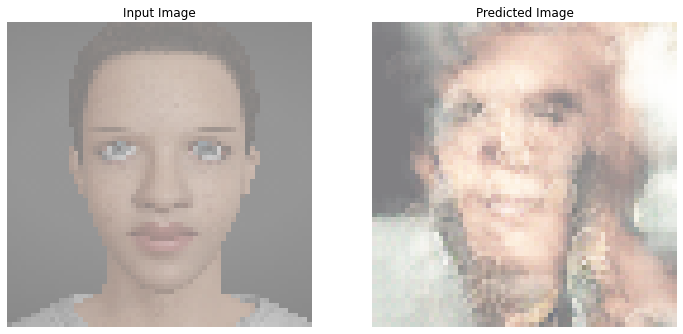

Time taken for epoch 11 is 638.7459790706635 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

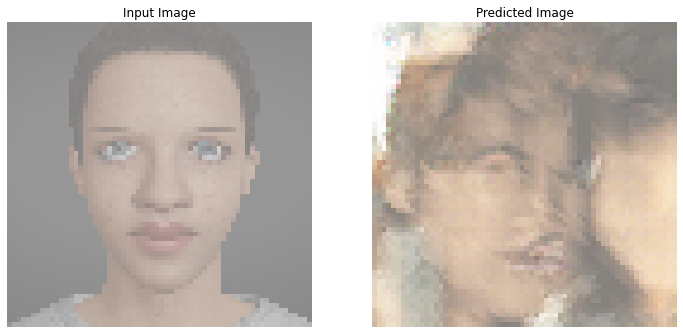

Time taken for epoch 12 is 643.5425565242767 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

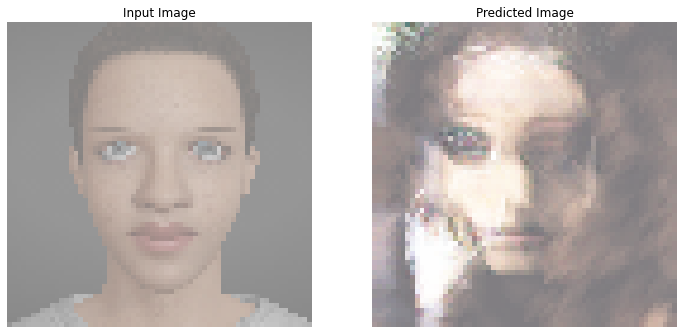

Time taken for epoch 13 is 654.8564274311066 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

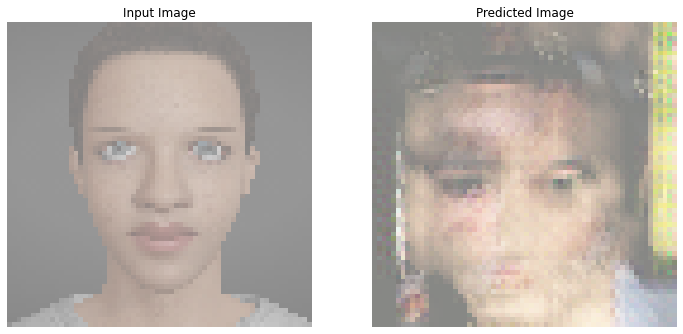

Time taken for epoch 14 is 639.5515828132629 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

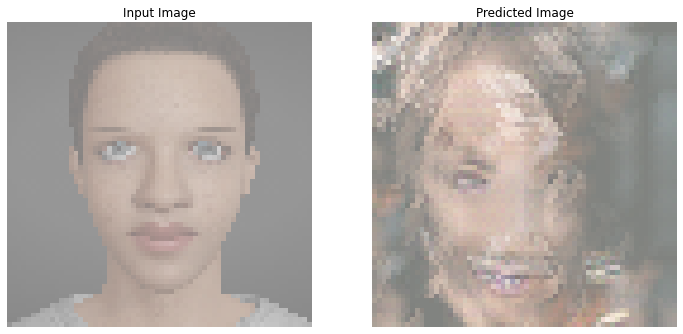

Saving checkpoint for epoch 15 at ./checkpoints/train/ckpt-3
Time taken for epoch 15 is 657.6022999286652 sec

.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

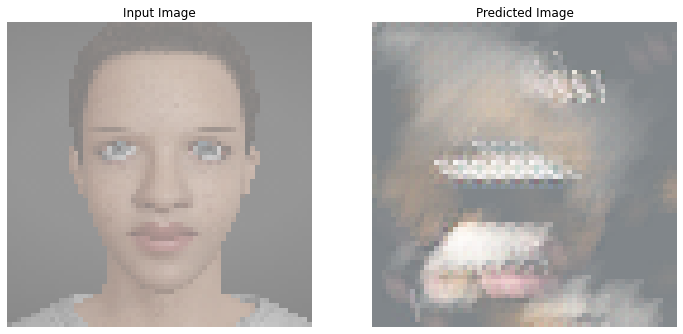

Time taken for epoch 16 is 657.2380359172821 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

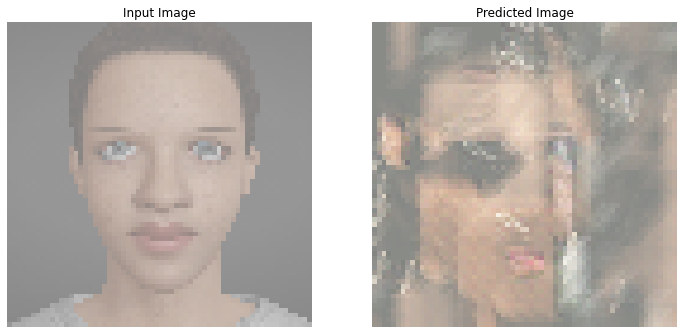

Time taken for epoch 17 is 654.4937529563904 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

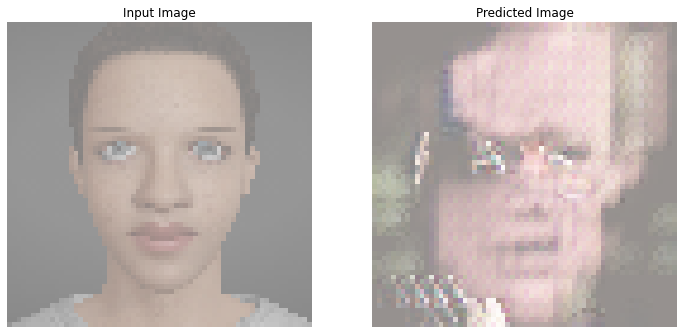

Time taken for epoch 18 is 654.5643558502197 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

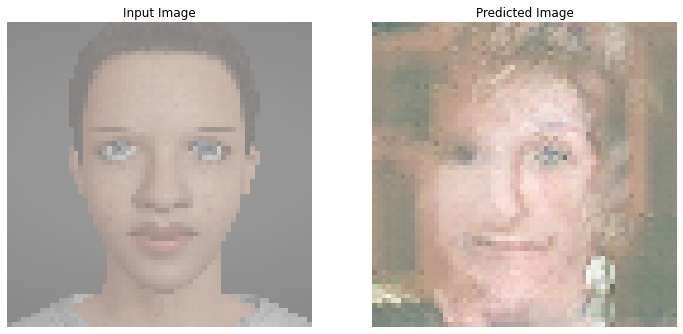

Time taken for epoch 19 is 642.3240706920624 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

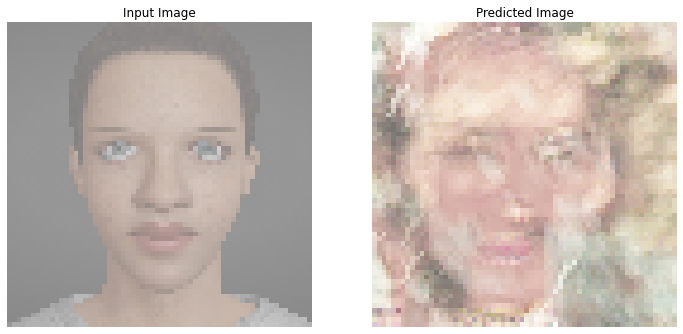

Saving checkpoint for epoch 20 at ./checkpoints/train/ckpt-4
Time taken for epoch 20 is 654.5652079582214 sec

.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

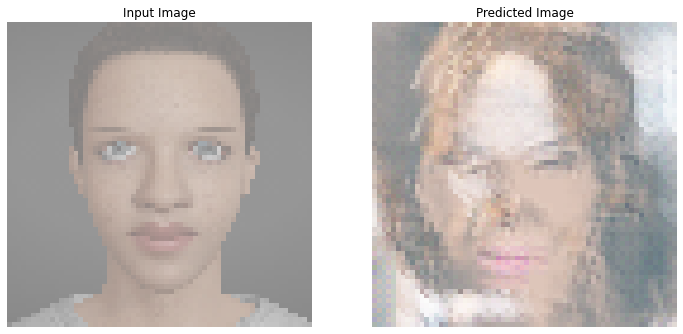

Time taken for epoch 21 is 642.3337712287903 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

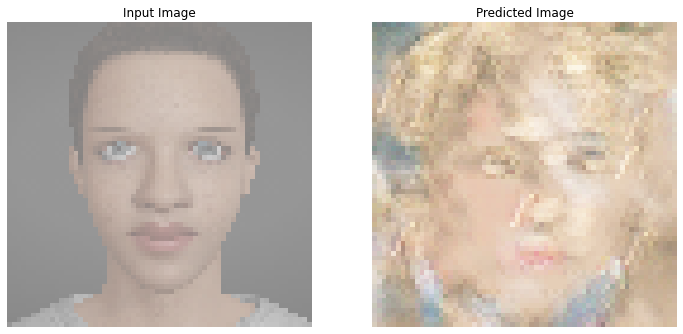

Time taken for epoch 22 is 649.1295969486237 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

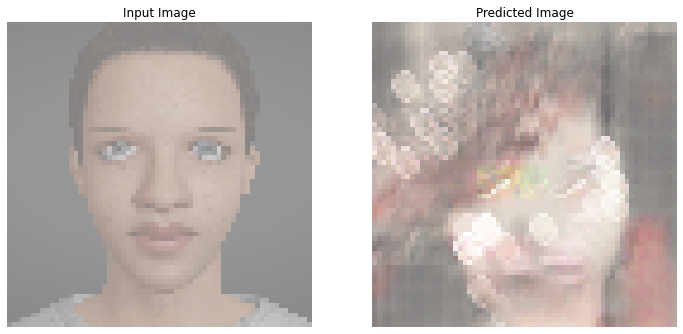

Time taken for epoch 23 is 655.9750781059265 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

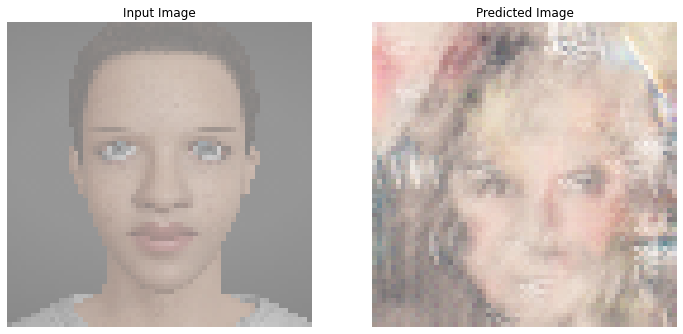

Time taken for epoch 24 is 642.4882819652557 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

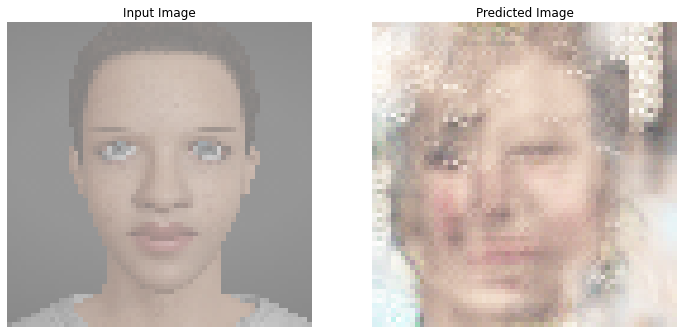

Saving checkpoint for epoch 25 at ./checkpoints/train/ckpt-5
Time taken for epoch 25 is 637.9285624027252 sec

.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

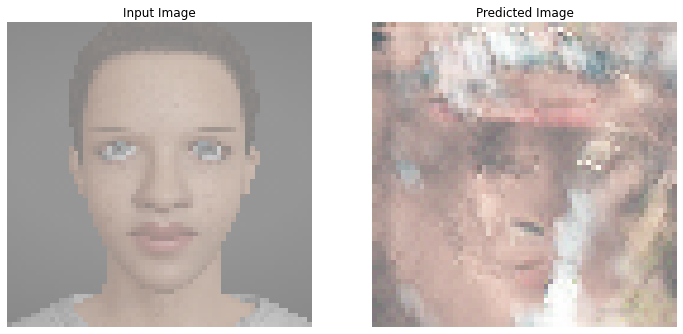

Time taken for epoch 26 is 655.8796150684357 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

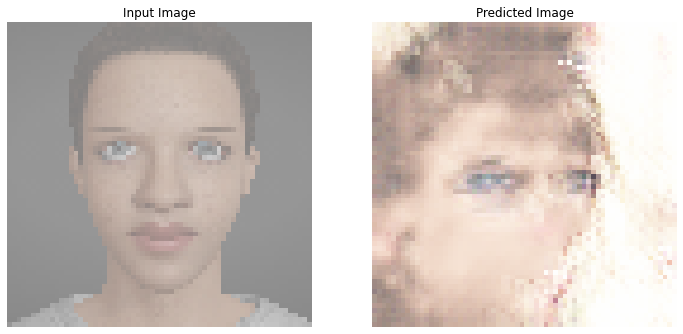

Time taken for epoch 27 is 656.1441514492035 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

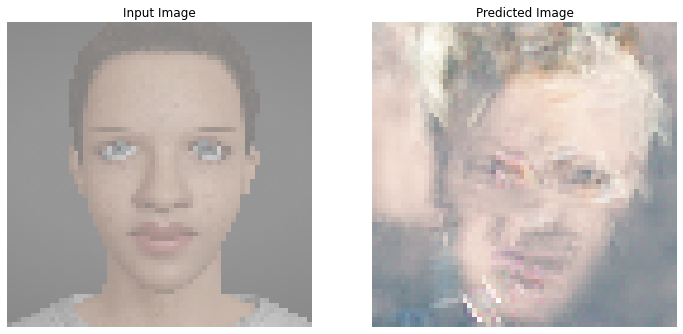

Time taken for epoch 28 is 654.7123036384583 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

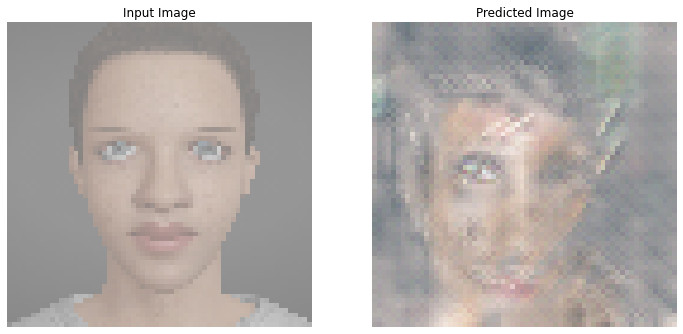

Time taken for epoch 29 is 656.4551348686218 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

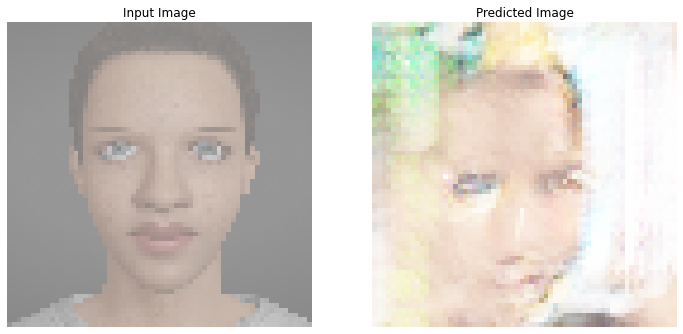

Saving checkpoint for epoch 30 at ./checkpoints/train/ckpt-6
Time taken for epoch 30 is 656.2222237586975 sec

.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

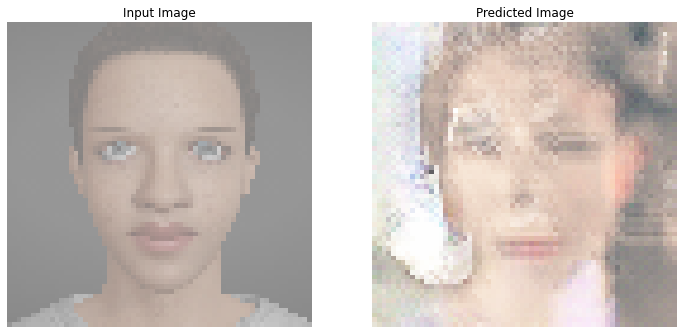

Time taken for epoch 31 is 655.9035246372223 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

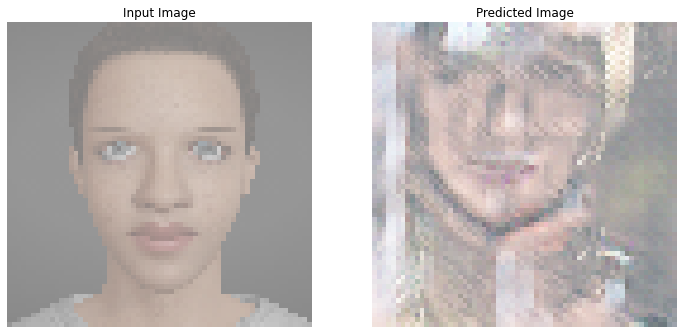

Time taken for epoch 32 is 656.2962758541107 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

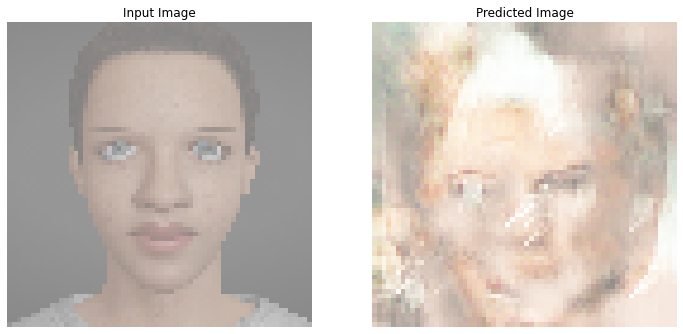

Time taken for epoch 33 is 643.8185515403748 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

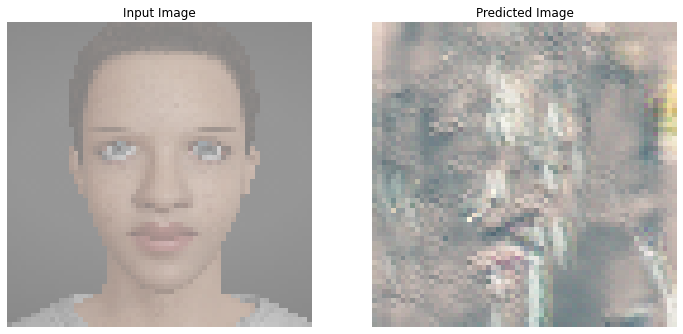

Time taken for epoch 34 is 655.4249632358551 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

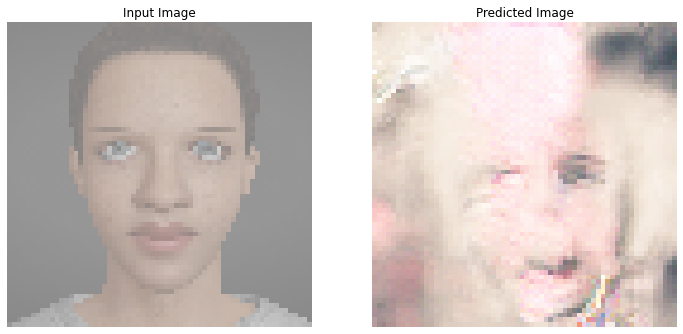

Saving checkpoint for epoch 35 at ./checkpoints/train/ckpt-7
Time taken for epoch 35 is 658.0887265205383 sec

.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

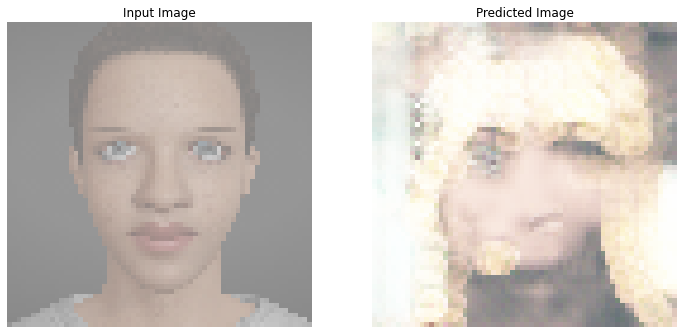

Time taken for epoch 36 is 641.2763192653656 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

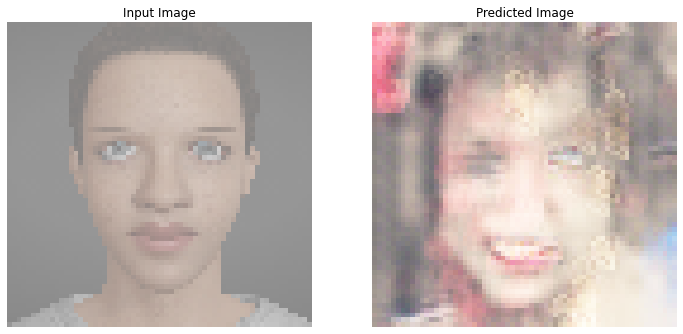

Time taken for epoch 37 is 647.8903639316559 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

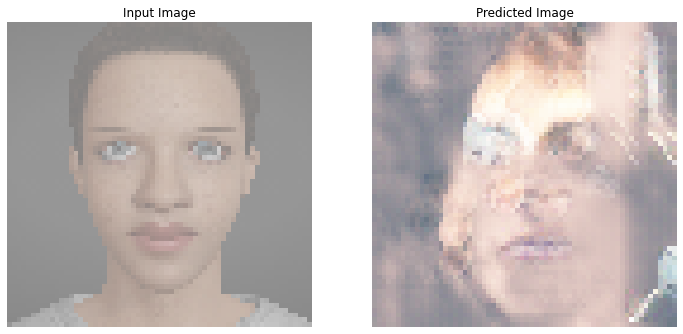

Time taken for epoch 38 is 638.3103897571564 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

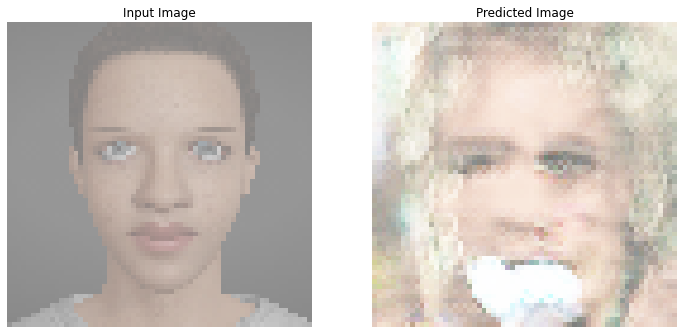

Time taken for epoch 39 is 648.1082665920258 sec

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

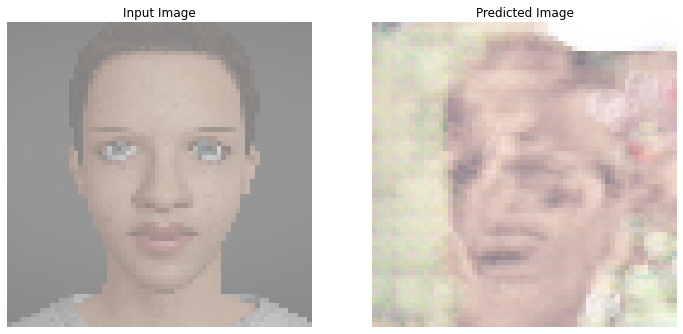

Saving checkpoint for epoch 40 at ./checkpoints/train/ckpt-8
Time taken for epoch 40 is 648.5348794460297 sec



In [17]:
# Training
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_comic, train_real)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    generate_images(generator, sample_comic)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1,
                                                            ckpt_save_path))

    print('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                       time.time() - start))

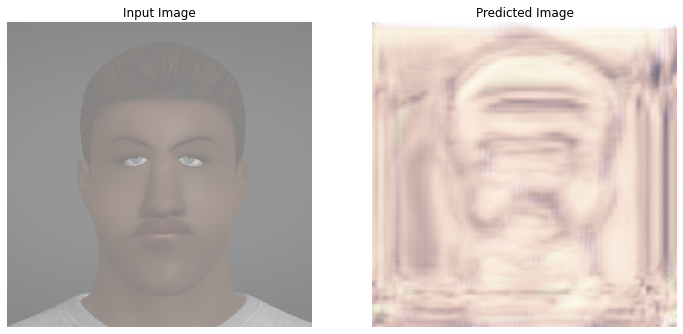

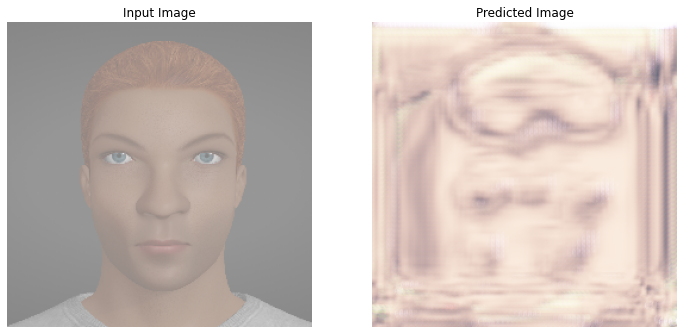

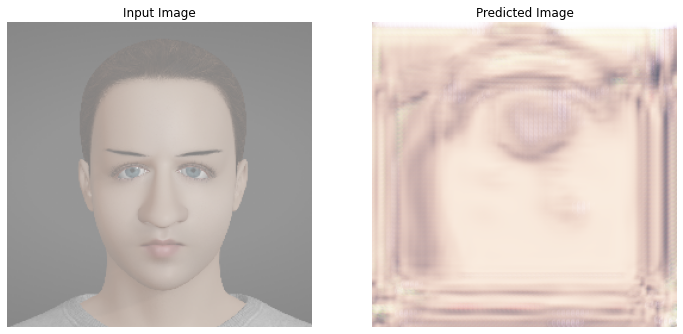

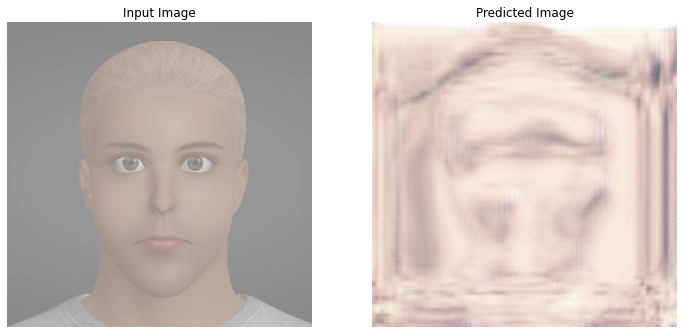

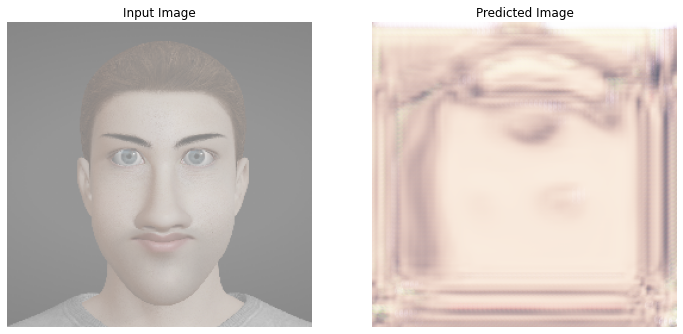

In [18]:
# Testing
for inp in test_comic.take(5):
    generate_images(generator, inp)